# Vision Transformers 
## Trabajo Práctico Final
### Noelia Qualindi - Matías Werbin

## Datasets
### Clasificación de Tumores Cerebrales

El dataset utilizado está compuesto por imágenes RGB que representan tres tipos de tumores cerebrales, así como imágenes que indican la ausencia de tumores. Las clases están etiquetadas de la siguiente manera:

- **0:** Glioma Tumor
- **1:** Meningioma Tumor
- **2:** No Tumor
- **3:** Pituitary Tumor

[**Fuente del Dataset**](https://huggingface.co/datasets/sartajbhuvaji/Brain-Tumor-Classification/viewer/default/Training?f[label][value]=2)


In [1]:
# Importación de librerías
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

c:\Users\matia\anaconda3\envs\cuda_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargar el dataset
dataset = load_dataset("sartajbhuvaji/Brain-Tumor-Classification")

# Separar dataset de Train y Test
train = dataset['Training']
test_dataset = dataset['Testing']

# Extraer etiquetas para la estratificación
labels = train['label']

# Generar índices estratificados
train_indices, val_indices = train_test_split(
    np.arange(len(labels)), 
    test_size=0.2, 
    stratify=labels,
    random_state=42
)

# Dividir el conjunto original en entrenamiento y validación
train_dataset = train.select(train_indices)
val_dataset = train.select(val_indices)

# Comprobar tamaños
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(val_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

c:\Users\matia\anaconda3\envs\cuda_env\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\matia\.cache\huggingface\hub\datasets--sartajbhuvaji--Brain-Tumor-Classification. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating Testing split: 100%|██████████| 394/394 [00:00<00:00, 765.86 examples/s]

Tamaño del conjunto de entrenamiento: 2296
Tamaño del conjunto de validación: 574
Tamaño del conjunto de prueba: 394


In [5]:
# Inspección Dataset descargado 
dataset

DatasetDict({
    Training: Dataset({
        features: ['image', 'label'],
        num_rows: 2870
    })
    Testing: Dataset({
        features: ['image', 'label'],
        num_rows: 394
    })
})

In [3]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 574
})

Primeras 3 imágenes en train_dataset


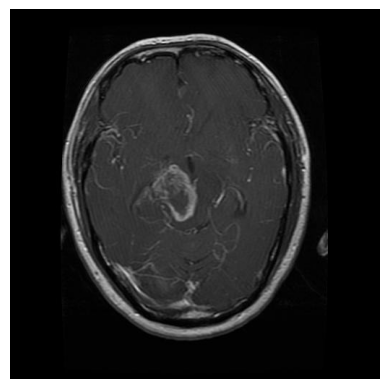

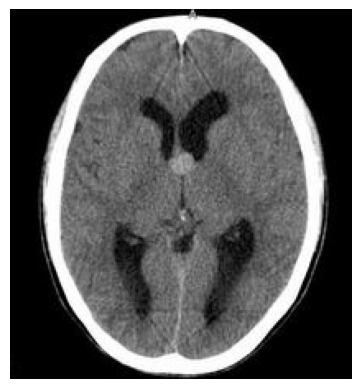

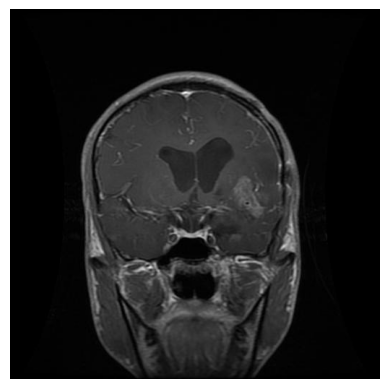

Primeras 3 imágenes en val_dataset


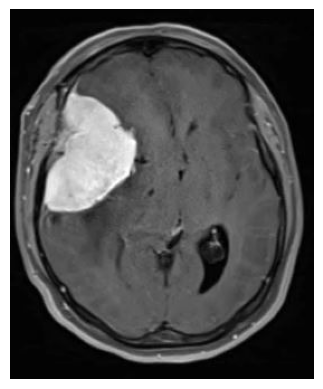

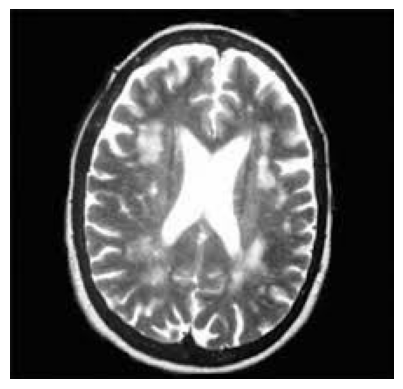

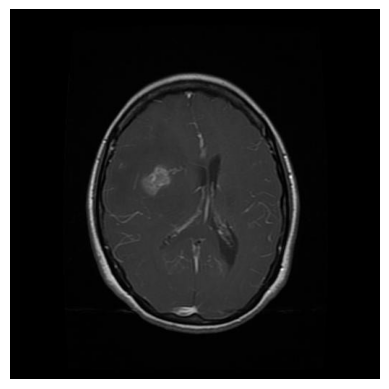

Primeras 3 imágenes en test_dataset


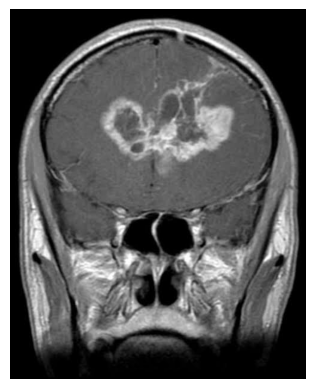

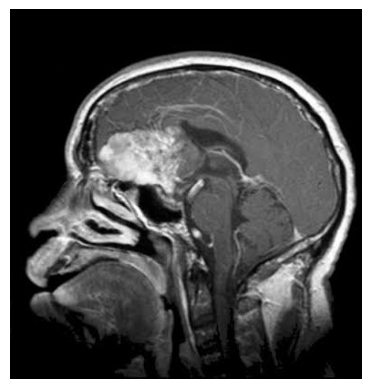

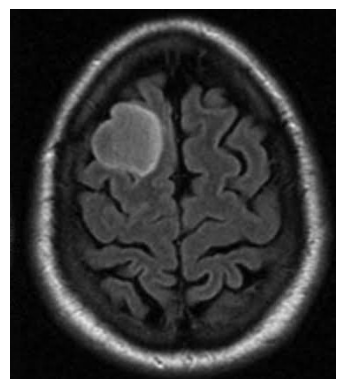

In [7]:
from PIL import Image

# Visualización de primeras tres imágenes de train_dataset
datasets = {'train_dataset': train_dataset, 'val_dataset': val_dataset, 'test_dataset': test_dataset}
for name, dataset in datasets.items():
    print(f"Primeras 3 imágenes en {name}")
    for i in range(3): 

        image_info = dataset['image'][i]

        if isinstance(image_info, Image.Image):
            image = image_info
        else:
            image = Image.open(image_info['src'])

        plt.imshow(image)
        plt.axis('off')
        plt.show()

    # print(f"Image {i + 1} info:", dataset['Training'][i])

### Clases del Dataset-Análisis de balanceo

In [19]:
# Generar diccionarios id2label y label2id para el mapeo-manejo de clases e ids
id2label = {id:label for id, label in enumerate(train_dataset.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

print(f"Diccionario id->label: {id2label}")
print("")
print(f"Diccionario label->id: {label2id}")

Diccionario id->label: {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

Diccionario label->id: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [10]:
from collections import Counter

# Convertir las etiquetas de tensores a enteros antes de contarlas
train_labels = [int(example['label']) for example in train_dataset]
valid_labels = [int(example['label']) for example in val_dataset]
test_labels = [int(example['label']) for example in test_dataset]

# Distribuciones de clases segun set
train_distribution = Counter(train_labels)
val_distribution = Counter(valid_labels)
test_distribution = Counter(test_labels)

print("Distribución en train:", train_distribution)
print("Distribución en valid:", val_distribution)
print("Distribución en test:", test_distribution)

Distribución en train: Counter({3: 662, 0: 661, 1: 657, 2: 316})
Distribución en valid: Counter({1: 165, 0: 165, 3: 165, 2: 79})
Distribución en test: Counter({1: 115, 2: 105, 0: 100, 3: 74})


In [15]:
train_distribution.keys()

dict_keys([0, 2, 1, 3])

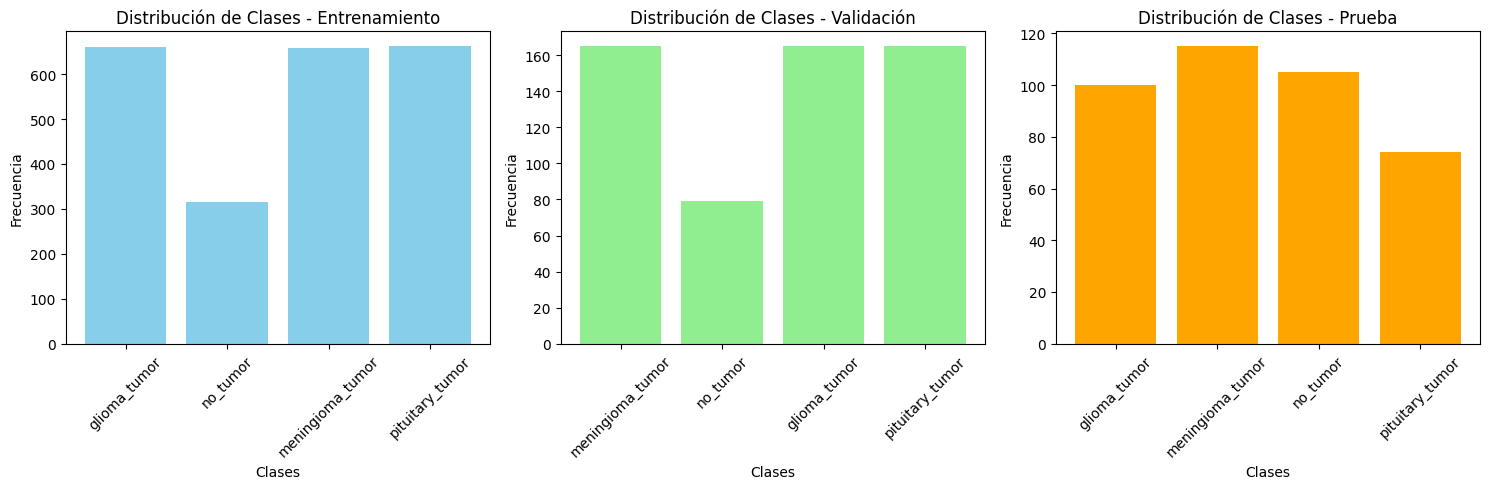

In [21]:
# Diccionario id->label
label2id = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

# Transformar las claves del Counter a nombres de clases
train_classes = [label2id[label] for label in train_distribution.keys()]
train_counts = list(train_distribution.values())

val_classes = [label2id[label] for label in val_distribution.keys()]
val_counts = list(val_distribution.values())

test_classes = [label2id[label] for label in test_distribution.keys()]
test_counts = list(test_distribution.values())

# Configuración de la gráfica para analizar balanceo
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Barplot para train_dataset
ax[0].bar(train_classes, train_counts, color='skyblue')
ax[0].set_title('Distribución de Clases - Entrenamiento')
ax[0].set_xlabel('Clases')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xticks(range(len(train_classes)))
ax[0].set_xticklabels(train_classes, rotation=45)

# Barplot para val_dataset
ax[1].bar(val_classes, val_counts, color='lightgreen')
ax[1].set_title('Distribución de Clases - Validación')
ax[1].set_xlabel('Clases')
ax[1].set_ylabel('Frecuencia')
ax[1].set_xticks(range(len(val_classes)))
ax[1].set_xticklabels(val_classes, rotation=45)

# Barplot para test_dataset
ax[2].bar(test_classes, test_counts, color='orange')
ax[2].set_title('Distribución de Clases - Prueba')
ax[2].set_xlabel('Clases')
ax[2].set_ylabel('Frecuencia')
ax[2].set_xticks(range(len(test_classes)))
ax[2].set_xticklabels(test_classes, rotation=45)

plt.tight_layout()
plt.show()




Podemos observar que tanto en el conjunto de entrenamiento como en el de validación existe un desbalance de clases. En este caso, la clase minoritaria es no_tumor. A priori, esto no debería representar un problema, ya que nuestro objetivo principal es que la red aprenda a clasificar correctamente las imágenes que contienen tumores y aquellas que no. Sin embargo, también es crucial poder predecir correctamente las imágenes sin tumores. A pesar de esto, en este tipo de problemas, es más crítico maximizar los verdaderos positivos (TP) de las clases asociadas a los tumores.

Podemos notar que el conjunto de prueba está bastante balanceado, por lo que podemos utilizar la precisión (accuracy) como métrica de evaluación.

### Set para CVT Model

In [13]:
# Renombrar datasets para el modelo de Cvt-13 de Microsoft
train_dataset_cvt = train_dataset
test_dataset_cvt = test_dataset
val_dataset_cvt = val_dataset

### Set para Base ViT Google

In [60]:
# Renombrar datasets para el modelo Vit Base de Google
train_dataset_g = train_dataset
test_dataset_g = test_dataset
val_dataset_g = val_dataset

### Set para Swin Transformer 

In [59]:
train_dataset_st = train_dataset
test_dataset_st = test_dataset
val_dataset_st = val_dataset

### Configuración del modelo CvT (Microsoft)

In [15]:
from transformers import AutoFeatureExtractor, CvtForImageClassification, Trainer, TrainingArguments
import torch

# Descargar modelo preentrenado como su correspondiente feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13')
model = CvtForImageClassification.from_pretrained('microsoft/cvt-13')


/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/envs/mipy/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /opt/anaconda3/envs/mipy/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta.

In [16]:
# Seteo de GPU si se encuentra disponible
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
model.to(device) # Visualiza arquitectura del modelo

mps


CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

##  Preprocesamiento, transformación y aumentación de datos


In [24]:
# Revisión de cantidad de datos en train antes de realizar data_aumentation
print(f"Data en Train antes de aplicar las transformaciones: {len(train_dataset)} imágenes ")

Data en Train antes de aplicar las transformaciones: 2296 imágenes 


In [18]:
from torchvision import transforms

# Data Aumentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

In [57]:
from datasets import load_dataset, concatenate_datasets
import random

# Función de aumentación y transformación de datos (con validación/conversión de imágen RGB -3 channnels). Dicha función, se aplicará unicamente en train_dataset
def augmented_train(example, feature_extractor):
    image = example['image']
    
    # Validación RGB
    if image.mode != 'RGB':
        image = image.convert("RGB")

    # Aumentación de datos
    augmented_image = train_transforms(image) 
    
    # Aplicación de feature_extractor asociado a CVT-13
    inputs = feature_extractor(images=augmented_image, return_tensors="pt", padding=True, do_rescale=False)
    example['pixel_values'] = inputs['pixel_values'].squeeze().to(device)
    example['label'] = example['label']
    return example

# Función de transformación de datos.
def transform(example, feature_extractor):
    image = example['image']
    
    if image.mode != 'RGB':
        image = image.convert("RGB")
    
    inputs = feature_extractor(images=image, return_tensors="pt", padding=True, do_rescale=False)
    example['pixel_values'] = inputs['pixel_values'].squeeze().to(device)
    example['label'] = example['label']
    return example



In [20]:
# Aumentación y tansformación de datos en train_dataset
augmented_cvt = train_dataset_cvt.map(lambda item: augmented_train(item, feature_extractor))

# Imputación de feature_extractor en en train, valid y test dataset
test_dataset_cvt = test_dataset_cvt.map(lambda item: transform(item, feature_extractor))
train_dataset_cvt = train_dataset_cvt.map(lambda item: transform(item, feature_extractor)) 
val_dataset_cvt = val_dataset_cvt.map(lambda item: transform(item, feature_extractor))

# Concatenar train_dataset original con el augmented_cvt (data aumentation)
train_dataset_cvt = concatenate_datasets([train_dataset_cvt, augmented_cvt])

Map:   0%|          | 0/2296 [00:00<?, ? examples/s]/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ConvNextFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Map: 100%|██████████| 574/574 [00:10<00:00, 54.87 examples/s]


In [22]:
# Inspeccioón de datasets luego de aumentación y transformación de datos 
print(f"Tamaño del conjunto de entrenamiento después del aumento de datos: {len(train_dataset_cvt)}") # Podemos observar el incremento de imágenes previo la aumentación: 2296 a post aumentación: 4592
print(f"Tamaño del conjunto de validación: {len(val_dataset_cvt)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset_cvt)}")

Tamaño del conjunto de entrenamiento después del aumento de datos: 4592
Tamaño del conjunto de validación: 574
Tamaño del conjunto de prueba: 394


In [23]:
# Seteo de datos torch para consumo de ViT
train_dataset_cvt.set_format(type='torch', columns=['pixel_values', 'label'])
val_dataset_cvt.set_format(type='torch', columns=['pixel_values', 'label'])
test_dataset_cvt.set_format(type='torch', columns=['pixel_values', 'label'])

In [25]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Función asociado al cálculo de métricas 
def compute_metrics(p):
    predictions, labels = p
    preds = torch.argmax(torch.tensor(predictions), axis=1)  # Predicción de clases
    labels = torch.tensor(labels)  # tensorizado de labels

    # Calcular métricas
    accuracy = accuracy_score(labels.numpy(), preds.numpy())  
    f1 = f1_score(labels.numpy(), preds.numpy(), average='weighted')  # F1-score ponderado
    recall = recall_score(labels.numpy(), preds.numpy(), average='weighted')  # Recall ponderado
    
    return {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
    }

In [26]:
import os
os.environ["WANDB_DISABLED"] = "true" # no utilizamos weights and biases

## Fine-Tuning

In [27]:
from transformers import TrainingArguments, Trainer

# Seteo de hiperparámetros
epochs = 10
learning_rate = 2e-5
batch_size_per_device = 16

class_names = {
    0: "glioma_tumor",
    1: "meningioma_tumor",
    2: "no_tumor",
    3: "pituitary_tumor"
}

# Seteo de TrainingArguments para Fine-Tuning
training_args = TrainingArguments(
    output_dir="./results",  # Directorio para guardar los resultados
    evaluation_strategy="epoch",  # Evaluar al final de cada época
    save_strategy="epoch",  # Guardar el modelo al final de cada época
    logging_strategy="epoch",
    learning_rate=learning_rate,  # Tasa de aprendizaje
    per_device_train_batch_size=batch_size_per_device,  # Tamaño del batch para entrenamiento
    per_device_eval_batch_size=batch_size_per_device,  # Tamaño del batch para evaluación
    num_train_epochs=epochs,  # Número de épocas
    weight_decay=0.01,  # Regularización L2
    logging_dir="./logs",  # Directorio para los logs
    logging_steps=10,  # Intervalo de pasos para registrar logs
    load_best_model_at_end=True,  # Cargar el mejor modelo al final
    metric_for_best_model="accuracy",  # Métrica para evaluar el mejor modelo
)

In [28]:
# Seteo de clase Trainer de Hugging Face
trainer = Trainer(
    model=model,  # Modelo a entrenar
    args=training_args,  # Parámetros de entrenamiento
    train_dataset=train_dataset_cvt,  # Conjunto de entrenamiento
    eval_dataset=val_dataset_cvt,  # Conjunto de validación
    tokenizer=feature_extractor,  # Tokenizer o extractor de características
    compute_metrics=compute_metrics,  # Función de evaluación
)

/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/var/folders/ml/g_sxsst10mj890krz6gpp0980000gn/T/ipykernel_82811/3214436591.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [29]:
# Entrenamiento de CVT-13
train_results = trainer.train()

 10%|█         | 287/2870 [02:34<21:38,  1.99it/s]

{'loss': 3.1523, 'grad_norm': 133.3999481201172, 'learning_rate': 1.8e-05, 'epoch': 1.0}


                                                  
 10%|█         | 287/2870 [02:41<21:38,  1.99it/s]

{'eval_loss': 0.8077149391174316, 'eval_accuracy': 0.7073170731707317, 'eval_f1': 0.7044083037030155, 'eval_recall': 0.7073170731707317, 'eval_runtime': 6.7084, 'eval_samples_per_second': 85.564, 'eval_steps_per_second': 5.366, 'epoch': 1.0}


 20%|██        | 574/2870 [05:10<20:25,  1.87it/s]  

{'loss': 1.1754, 'grad_norm': 265.5242004394531, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}


                                                  
 20%|██        | 574/2870 [05:16<20:25,  1.87it/s]

{'eval_loss': 0.521224319934845, 'eval_accuracy': 0.7926829268292683, 'eval_f1': 0.7930413186486681, 'eval_recall': 0.7926829268292683, 'eval_runtime': 5.6679, 'eval_samples_per_second': 101.272, 'eval_steps_per_second': 6.352, 'epoch': 2.0}


 30%|███       | 861/2870 [07:47<18:06,  1.85it/s]  

{'loss': 0.8645, 'grad_norm': 97.42633056640625, 'learning_rate': 1.4e-05, 'epoch': 3.0}


                                                  
 30%|███       | 861/2870 [07:52<18:06,  1.85it/s]

{'eval_loss': 0.46796876192092896, 'eval_accuracy': 0.8240418118466899, 'eval_f1': 0.8240317011678377, 'eval_recall': 0.8240418118466899, 'eval_runtime': 5.7227, 'eval_samples_per_second': 100.302, 'eval_steps_per_second': 6.291, 'epoch': 3.0}


 40%|████      | 1148/2870 [10:28<14:49,  1.94it/s] 

{'loss': 0.8433, 'grad_norm': 132.46726989746094, 'learning_rate': 1.2e-05, 'epoch': 4.0}


                                                   
 40%|████      | 1148/2870 [10:33<14:49,  1.94it/s]

{'eval_loss': 0.4499412178993225, 'eval_accuracy': 0.8310104529616724, 'eval_f1': 0.8293476421040136, 'eval_recall': 0.8310104529616724, 'eval_runtime': 5.7921, 'eval_samples_per_second': 99.101, 'eval_steps_per_second': 6.215, 'epoch': 4.0}


 50%|█████     | 1435/2870 [13:05<11:38,  2.05it/s]  

{'loss': 0.75, 'grad_norm': 57.15482711791992, 'learning_rate': 1e-05, 'epoch': 5.0}


                                                   
 50%|█████     | 1435/2870 [13:10<11:38,  2.05it/s]

{'eval_loss': 0.4259687066078186, 'eval_accuracy': 0.8344947735191638, 'eval_f1': 0.8322147148059503, 'eval_recall': 0.8344947735191638, 'eval_runtime': 5.3636, 'eval_samples_per_second': 107.018, 'eval_steps_per_second': 6.712, 'epoch': 5.0}


 60%|██████    | 1722/2870 [15:42<09:55,  1.93it/s]

{'loss': 0.7303, 'grad_norm': 54.297908782958984, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}


                                                   
 60%|██████    | 1722/2870 [15:47<09:55,  1.93it/s]

{'eval_loss': 0.48117595911026, 'eval_accuracy': 0.8292682926829268, 'eval_f1': 0.8282083354697497, 'eval_recall': 0.8292682926829268, 'eval_runtime': 5.4786, 'eval_samples_per_second': 104.771, 'eval_steps_per_second': 6.571, 'epoch': 6.0}


 70%|███████   | 2009/2870 [18:17<07:18,  1.96it/s]

{'loss': 0.7013, 'grad_norm': 46.586769104003906, 'learning_rate': 6e-06, 'epoch': 7.0}


                                                   
 70%|███████   | 2009/2870 [18:23<07:18,  1.96it/s]

{'eval_loss': 0.39135295152664185, 'eval_accuracy': 0.8205574912891986, 'eval_f1': 0.8143466429524296, 'eval_recall': 0.8205574912891986, 'eval_runtime': 5.742, 'eval_samples_per_second': 99.965, 'eval_steps_per_second': 6.27, 'epoch': 7.0}


 80%|████████  | 2296/2870 [20:55<05:06,  1.87it/s]

{'loss': 0.6834, 'grad_norm': 137.60440063476562, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}


                                                   
 80%|████████  | 2296/2870 [21:01<05:06,  1.87it/s]

{'eval_loss': 0.3996467590332031, 'eval_accuracy': 0.8536585365853658, 'eval_f1': 0.8531528593185012, 'eval_recall': 0.8536585365853658, 'eval_runtime': 5.4423, 'eval_samples_per_second': 105.47, 'eval_steps_per_second': 6.615, 'epoch': 8.0}


 90%|█████████ | 2583/2870 [23:34<02:19,  2.06it/s]

{'loss': 0.6825, 'grad_norm': 254.84799194335938, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.0}


                                                   
 90%|█████████ | 2583/2870 [23:39<02:19,  2.06it/s]

{'eval_loss': 0.3744327127933502, 'eval_accuracy': 0.8745644599303136, 'eval_f1': 0.8738582455671867, 'eval_recall': 0.8745644599303136, 'eval_runtime': 5.3882, 'eval_samples_per_second': 106.529, 'eval_steps_per_second': 6.681, 'epoch': 9.0}


100%|██████████| 2870/2870 [26:17<00:00,  1.97it/s]

{'loss': 0.6537, 'grad_norm': 37.91458511352539, 'learning_rate': 0.0, 'epoch': 10.0}


                                                   
100%|██████████| 2870/2870 [26:22<00:00,  1.97it/s]

{'eval_loss': 0.3659678101539612, 'eval_accuracy': 0.8693379790940766, 'eval_f1': 0.8695248003382784, 'eval_recall': 0.8693379790940766, 'eval_runtime': 5.7331, 'eval_samples_per_second': 100.12, 'eval_steps_per_second': 6.279, 'epoch': 10.0}


100%|██████████| 2870/2870 [26:25<00:00,  1.81it/s]

{'train_runtime': 1585.2813, 'train_samples_per_second': 28.966, 'train_steps_per_second': 1.81, 'train_loss': 1.0236623571309478, 'epoch': 10.0}


**Conclusión**

El modelo muestra una pérdida de entrenamiento que disminuye progresivamente desde 3.15 en la primera época hasta 0.65 en la última, indicando un aprendizaje consistente. En validación, la pérdida baja de 0.81 a 0.37, lo que respalda la mejora del desempeño. El accuracy y el F1 final alcanzan 86.93% y 86.95%, respectivamente, mientras que el recall sigue una tendencia similar, reflejando un buen equilibrio en las predicciones.

Aunque el rendimiento es bueno, los picos de gradiente elevados en épocas específicas (265.52 en la época 2 y 254.85 en la época 9) podrían ser indicadores de inestabilidad en el entrenamiento, lo que sugiere la necesidad de ajustar parámetros como el learning rate o la regularización.

In [30]:
# Guardar el modeñp
torch.save(model.state_dict(), 'modelo_entrenado_cvt_fine_tuning.pth')

In [31]:
# Limpieza de cache
torch.mps.empty_cache() 

### Evaluación del modelo con Fine-Tuning

In [41]:
from sklearn.metrics import classification_report

def evaluate_model(model, test_dataset, batch_size_per_device=8, device='cuda'):
    test_loader = DataLoader(test_dataset, batch_size=batch_size_per_device)

    model.eval() 
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch['pixel_values'].squeeze(1).float()
            outputs = model(pixel_values=pixel_values.to(device))  # Forward pass
            predictions = torch.argmax(outputs.logits, dim=-1)
            
            # Almacenar las predicciones y etiquetas reales
            all_preds.extend(predictions.cpu().numpy()) 
            all_labels.extend(batch['label'].cpu().numpy())

    # Imprimir el classification report
    print(classification_report(all_labels, all_preds, digits=4))

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_predictions(test_dataset, predictions, class_names, num_samples=15, rows=3, cols=5):
    """
    Función para mostrar imágenes de un dataset con sus etiquetas verdaderas y predicciones.
    
    Parameters:
    - test_dataset: Dataset de prueba.
    - predictions: Resultados de las predicciones del modelo (con `trainer.predict()`).
    - class_names: Diccionario que mapea las etiquetas numéricas a nombres de clase.
    - num_samples: Número de imágenes a mostrar.
    - rows: Número de filas en la figura.
    - cols: Número de columnas en la figura.
    """
    predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)
    
    random_indices = random.sample(range(len(test_dataset)), num_samples)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Tamaño de la figura
    axes = axes.flatten()

    for idx, ax in zip(random_indices, axes):
        sample = test_dataset[idx]
        image = sample['pixel_values']
        true_label = int(sample['label']) 
        
        true_label_name = class_names[true_label]
        pred_label_name = class_names[predicted_labels[idx].item()]
        
        # Ajusta la imagen a formato [H, W, C]
        image = image.permute(1, 2, 0).numpy()  # cambia de [C, H, W] a [H, W, C]
        
        # Normalizar la imagen si es necesario
        if image.max() > 1 or image.min() < 0:
            image = (image - image.min()) / (image.max() - image.min())  # normalizar entre 0 y 1
        
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", fontsize=10)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(predictions, class_names):
    # Obtener las etiquetas verdaderas y las predicciones
    y_true = predictions.label_ids
    y_pred = predictions.predictions.argmax(axis=1)
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Etiquetas para las clases
    labels = [class_names[i] for i in range(len(class_names))]
    
    # Crear la visualización de la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # Mostrar la matriz de confusión
    disp.plot(cmap='plasma', xticks_rotation=45)
    plt.title("Matriz de Confusión")
    plt.show()


#### Métricas para Test

In [47]:
evaluate_model(model, test_dataset_cvt, batch_size_per_device, device)

              precision    recall  f1-score   support

           0     0.8750    0.2100    0.3387       100
           1     0.5922    0.5304    0.5596       115
           2     0.4367    0.9524    0.5988       105
           3     0.8158    0.4189    0.5536        74

    accuracy                         0.5406       394
   macro avg     0.6799    0.5279    0.5127       394
weighted avg     0.6645    0.5406    0.5129       394



**Conclusiones:**

- Accuracy General:

El accuracy obtenido en la evaluación del conjunto de validación es 54.06%, lo cual indica que el modelo tiene un desempeño aceptable pero podría mejorar. Tener en cuenta que la red fue preentreanda para clases muy distitnas a las que esta intentando clasificar y fue entrenado solamente por 10 epochs.

- Desempeño por Clase:

    -Clase 0: Alta precisión (87.50%) pero bajo recall (21.00%), lo que sugiere que el modelo no está capturando correctamente esta clase y genera muchos **falsos negativos**.
    -Clase 1: Moderada precisión (59.22%) y recall (53.04%), indicando un balance razonable aunque mejorable (moderados fp y fn).
    -Clase 2: Bajo precision (43.67%) pero alto recall (95.24%), lo que implica que el modelo clasifica casi todos los ejemplos como clase 2, pero con muchos **falsos positivos**.
    -Clase 3: Alta precisión (81.58%) pero bajo recall (41.89%), mostrando un problema similar al de la clase 0 con **falsos negativos**.

- Promedios:

- Macro avg:

El F1-score promedio de 51.27% muestra que el desempeño general es moderado pero desigual entre las clases. Esto podría deberse a que el modelo tiene dificultades para capturar correctamente algunas características específicas de ciertas clases, lo que afecta su capacidad para generalizar.

- Weighted avg:

El F1-score ponderado de 51.29% indica que, aunque las clases no están significativamente desbalanceadas en términos de cantidad, el modelo aún favorece las clases con características más distintivas o que se ajustan mejor a los patrones aprendidos, lo que puede llevar a un desempeño inconsistente en otras clases.

#### Pruebas 

100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


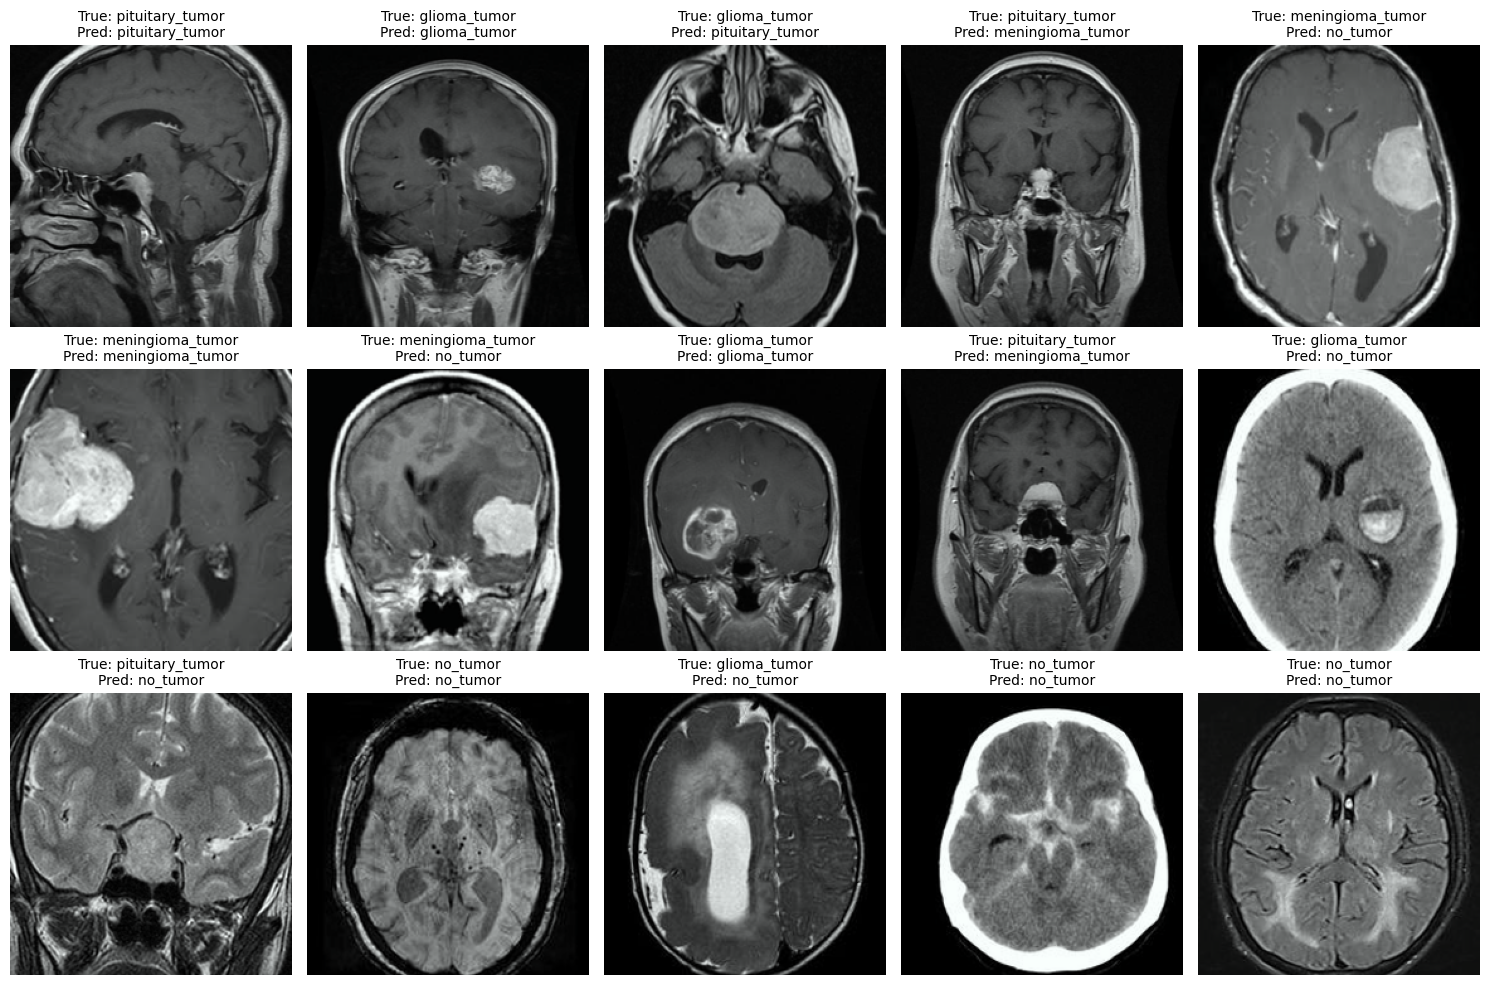

In [48]:
# Predicciones
predictions_cvt = trainer.predict(test_dataset_cvt)
predicted_labels_cvt = torch.argmax(torch.tensor(predictions_cvt.predictions), dim=-1)

# Ploteo de imágenes con predicciones y ground truth (labels)
plot_predictions(test_dataset_cvt, predictions_cvt, class_names)

In [49]:
# Métricas asociadas a test segun predicciones
predictions_cvt.metrics

{'test_loss': 1.9361610412597656,
 'test_accuracy': 0.5406091370558376,
 'test_f1': 0.5128611754273218,
 'test_recall': 0.5406091370558376,
 'test_runtime': 4.1621,
 'test_samples_per_second': 94.664,
 'test_steps_per_second': 6.007}

### Matriz de confusión

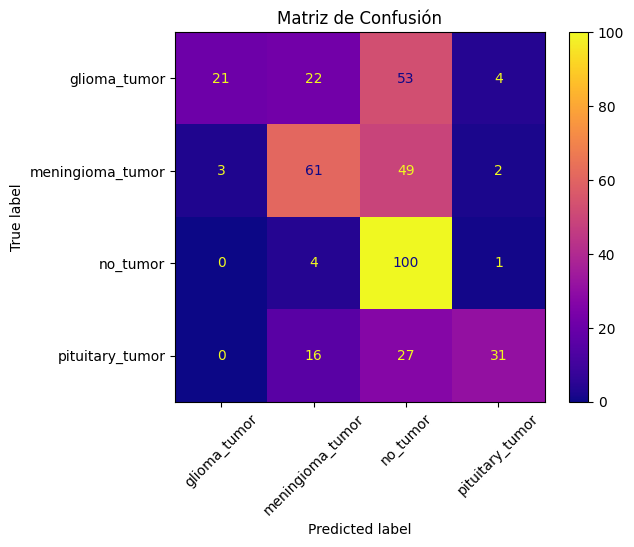

In [52]:
plot_confusion_matrix(predictions_cvt, class_names)

## Configuración del modelo ViT- Base (Google)

In [55]:
from transformers import ViTImageProcessor, ViTForImageClassification

# Descargar modelo preentrando como su correspondiente procesador de datos
feature_extractor_g = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model_g = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

In [56]:
model_g.to(device) # Envío del modelo a device y visualización de arquitectura

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [61]:
# Aumentación y tansformación de datos en train_dataset
augmented_g = train_dataset_g.map(lambda item: augmented_train(item, feature_extractor_g))

# Imputación de feature_extractor en en train, valid y test dataset
test_dataset_g = test_dataset_g.map(lambda item: transform(item, feature_extractor_g))
val_dataset_g = val_dataset_g.map(lambda item: transform(item, feature_extractor_g))
train_dataset_g = train_dataset_g.map(lambda item: transform(item, feature_extractor_g))


# Concatenar train_dataset original con el augmented_g (data aumentation)
train_dataset_g = concatenate_datasets([train_dataset_g, augmented_g])

Map:   0%|          | 0/394 [00:00<?, ? examples/s]/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Map: 100%|██████████| 2296/2296 [00:46<00:00, 49.91 examples/s]


In [62]:
# Inspección datasets luego de aumentación y procesamiento de datos
print(f"Tamaño del conjunto de entrenamiento después del aumento de datos: {len(train_dataset_g)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset_g)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset_g)}")

Tamaño del conjunto de entrenamiento después del aumento de datos: 4592
Tamaño del conjunto de validación: 574
Tamaño del conjunto de prueba: 394


In [63]:
# Seteo de datos torch para consumo de ViT
train_dataset_g.set_format(type='torch', columns=['pixel_values', 'label'])
val_dataset_g.set_format(type='torch', columns=['pixel_values', 'label'])
test_dataset_g.set_format(type='torch', columns=['pixel_values', 'label'])

In [65]:
# Seteo de Clase Trainer de Hugging Face
trainer_g = Trainer(
    model=model_g,  # Modelo a entrenar
    args=training_args,  # Parámetros de entrenamiento
    train_dataset=train_dataset_g,  # Conjunto de entrenamiento
    eval_dataset=val_dataset_g,  # Conjunto de validación
    tokenizer=feature_extractor_g,  # Tokenizer o extractor de características
    compute_metrics=compute_metrics,  # Función de evaluación
)

/var/folders/ml/g_sxsst10mj890krz6gpp0980000gn/T/ipykernel_82811/75566769.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_g = Trainer(


In [66]:
# Entrenamiento
trainer_g_results = trainer_g.train()

  0%|          | 0/2870 [00:00<?, ?it/s]

 10%|█         | 287/2870 [03:52<32:30,  1.32it/s]

{'loss': 1.5779, 'grad_norm': 118.0350341796875, 'learning_rate': 1.8e-05, 'epoch': 1.0}



 10%|█         | 287/2870 [04:03<32:30,  1.32it/s]

{'eval_loss': 1.0000718832015991, 'eval_accuracy': 0.5749128919860628, 'eval_f1': 0.5380530299129362, 'eval_recall': 0.5749128919860628, 'eval_runtime': 10.9984, 'eval_samples_per_second': 52.19, 'eval_steps_per_second': 3.273, 'epoch': 1.0}


 20%|██        | 574/2870 [07:41<28:11,  1.36it/s]  

{'loss': 0.5669, 'grad_norm': 805.7055053710938, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}



 20%|██        | 574/2870 [07:52<28:11,  1.36it/s]

{'eval_loss': 0.82784503698349, 'eval_accuracy': 0.6480836236933798, 'eval_f1': 0.6497414725369595, 'eval_recall': 0.6480836236933798, 'eval_runtime': 10.8293, 'eval_samples_per_second': 53.004, 'eval_steps_per_second': 3.324, 'epoch': 2.0}


 30%|███       | 861/2870 [11:26<23:22,  1.43it/s]  

{'loss': 0.434, 'grad_norm': 170.71466064453125, 'learning_rate': 1.4e-05, 'epoch': 3.0}



 30%|███       | 861/2870 [11:36<23:22,  1.43it/s]

{'eval_loss': 0.694048285484314, 'eval_accuracy': 0.7421602787456446, 'eval_f1': 0.7385515695328065, 'eval_recall': 0.7421602787456446, 'eval_runtime': 9.7359, 'eval_samples_per_second': 58.957, 'eval_steps_per_second': 3.698, 'epoch': 3.0}


 40%|████      | 1148/2870 [15:04<21:04,  1.36it/s] 

{'loss': 0.3907, 'grad_norm': 41.882057189941406, 'learning_rate': 1.2e-05, 'epoch': 4.0}



 40%|████      | 1148/2870 [15:15<21:04,  1.36it/s]

{'eval_loss': 0.6786361932754517, 'eval_accuracy': 0.7386759581881533, 'eval_f1': 0.7461051742263304, 'eval_recall': 0.7386759581881533, 'eval_runtime': 10.4306, 'eval_samples_per_second': 55.031, 'eval_steps_per_second': 3.451, 'epoch': 4.0}


 50%|█████     | 1435/2870 [18:46<16:53,  1.42it/s]  

{'loss': 0.3489, 'grad_norm': 524.9801025390625, 'learning_rate': 1e-05, 'epoch': 5.0}



 50%|█████     | 1435/2870 [18:57<16:53,  1.42it/s]

{'eval_loss': 0.6579709649085999, 'eval_accuracy': 0.7700348432055749, 'eval_f1': 0.765707314203539, 'eval_recall': 0.7700348432055749, 'eval_runtime': 10.3835, 'eval_samples_per_second': 55.28, 'eval_steps_per_second': 3.467, 'epoch': 5.0}


 60%|██████    | 1722/2870 [22:25<13:35,  1.41it/s]  

{'loss': 0.2926, 'grad_norm': 658.5289306640625, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}



 60%|██████    | 1722/2870 [22:35<13:35,  1.41it/s]

{'eval_loss': 0.5878684520721436, 'eval_accuracy': 0.7682926829268293, 'eval_f1': 0.7542894198807757, 'eval_recall': 0.7682926829268293, 'eval_runtime': 10.188, 'eval_samples_per_second': 56.341, 'eval_steps_per_second': 3.534, 'epoch': 6.0}


 70%|███████   | 2009/2870 [26:03<10:08,  1.41it/s]  

{'loss': 0.2501, 'grad_norm': 348.32891845703125, 'learning_rate': 6e-06, 'epoch': 7.0}



 70%|███████   | 2009/2870 [26:13<10:08,  1.41it/s]

{'eval_loss': 0.528950572013855, 'eval_accuracy': 0.7874564459930313, 'eval_f1': 0.7902383247870335, 'eval_recall': 0.7874564459930313, 'eval_runtime': 9.9662, 'eval_samples_per_second': 57.595, 'eval_steps_per_second': 3.612, 'epoch': 7.0}


 80%|████████  | 2296/2870 [29:40<06:42,  1.43it/s]  

{'loss': 0.2227, 'grad_norm': 517.445068359375, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}



 80%|████████  | 2296/2870 [29:50<06:42,  1.43it/s]

{'eval_loss': 0.5058793425559998, 'eval_accuracy': 0.7961672473867596, 'eval_f1': 0.7879089299467674, 'eval_recall': 0.7961672473867596, 'eval_runtime': 9.9986, 'eval_samples_per_second': 57.408, 'eval_steps_per_second': 3.6, 'epoch': 8.0}


 90%|█████████ | 2583/2870 [33:20<03:29,  1.37it/s]

{'loss': 0.1985, 'grad_norm': 306.4830322265625, 'learning_rate': 2.0000000000000003e-06, 'epoch': 9.0}



 90%|█████████ | 2583/2870 [33:30<03:29,  1.37it/s]

{'eval_loss': 0.5106233358383179, 'eval_accuracy': 0.8066202090592335, 'eval_f1': 0.8088914563134064, 'eval_recall': 0.8066202090592335, 'eval_runtime': 10.2392, 'eval_samples_per_second': 56.059, 'eval_steps_per_second': 3.516, 'epoch': 9.0}


100%|██████████| 2870/2870 [37:04<00:00,  1.38it/s]

{'loss': 0.1815, 'grad_norm': 8.001798629760742, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 2870/2870 [37:15<00:00,  1.38it/s]

{'eval_loss': 0.48943623900413513, 'eval_accuracy': 0.8222996515679443, 'eval_f1': 0.8203341663841328, 'eval_recall': 0.8222996515679443, 'eval_runtime': 11.5805, 'eval_samples_per_second': 49.566, 'eval_steps_per_second': 3.109, 'epoch': 10.0}


100%|██████████| 2870/2870 [37:17<00:00,  1.28it/s]

{'train_runtime': 2237.6434, 'train_samples_per_second': 20.522, 'train_steps_per_second': 1.283, 'train_loss': 0.4463636272044963, 'epoch': 10.0}



**Conclusión:**

El modelo muestra un progreso constante durante el entrenamiento, reduciendo la pérdida de evaluación de 1.00 en la primera época a 0.49 al final. La precisión y el F1-score también mejoran a lo largo de las épocas, alcanzando valores finales de 82.23% y 82.03%, respectivamente, lo que indica un buen desempeño general en la tarea de clasificación.

Sin embargo, se observa un comportamiento inestable en las normativas de gradiente en ciertas épocas, como un valor de 805.70 en la época 2 y 658.53 en la época 6. Esto sugiere que podría haber picos en el gradiente que afecten el proceso de optimización. A pesar de esto, la métrica de evaluación final sugiere que el modelo es aceptable.

Se recomienda analizar los gradientes más a fondo y ajustar hiperparámetros como la tasa de aprendizaje o introducir estrategias de clip de gradiente para evitar posibles problemas de inestabilidad en entrenamientos futuros (fuera del alcance de práctico final por cuestiones de tiempo y costo computacional pero sería buena práctica realizarlo). Los resultados finales en un conjunto de prueba adicional confirmarán la validez de estas métricas 

### Evaluación del modelo con Fine-Tuning

#### Métricas de Evaluación

In [69]:
evaluate_model(model_g, test_dataset_g, batch_size_per_device, device)

              precision    recall  f1-score   support

           0     0.7895    0.1500    0.2521       100
           1     0.5106    0.2087    0.2963       115
           2     0.3411    0.9714    0.5050       105
           3     0.5862    0.2297    0.3301        74

    accuracy                         0.4010       394
   macro avg     0.5569    0.3900    0.3459       394
weighted avg     0.5504    0.4010    0.3470       394



**Conclusión:**
- Accuracy General:

El accuracy obtenido es 40.10%, lo que refleja un desempeño limitado del modelo y sugiere que necesita mejoras.

- Desempeño por Clase:

    - Clase 0: Precisión moderada (78.95%) pero muy bajo recall (15.00%), indicando que el modelo tiene dificultades para identificar ejemplos de esta clase y genera muchos **falsos negativos**.
    - Clase 1: Precisión baja (51.06%) y recall bajo (20.87%), lo que muestra que esta clase es mal clasificada en ambos aspectos (moderados FP y altos FN).
    - Clase 2: Precisión baja (34.11%) pero recall muy alto (97.14%), lo que sugiere que el modelo clasifica muchos ejemplos como esta clase, generando un alto número de **falsos positivos**.
    - Clase 3: Precisión moderada (58.62%) pero recall bajo (22.97%), lo que implica que el modelo identifica tiene problemas similares a la clase 1.

#### Pruebas

100%|██████████| 25/25 [00:06<00:00,  4.05it/s]


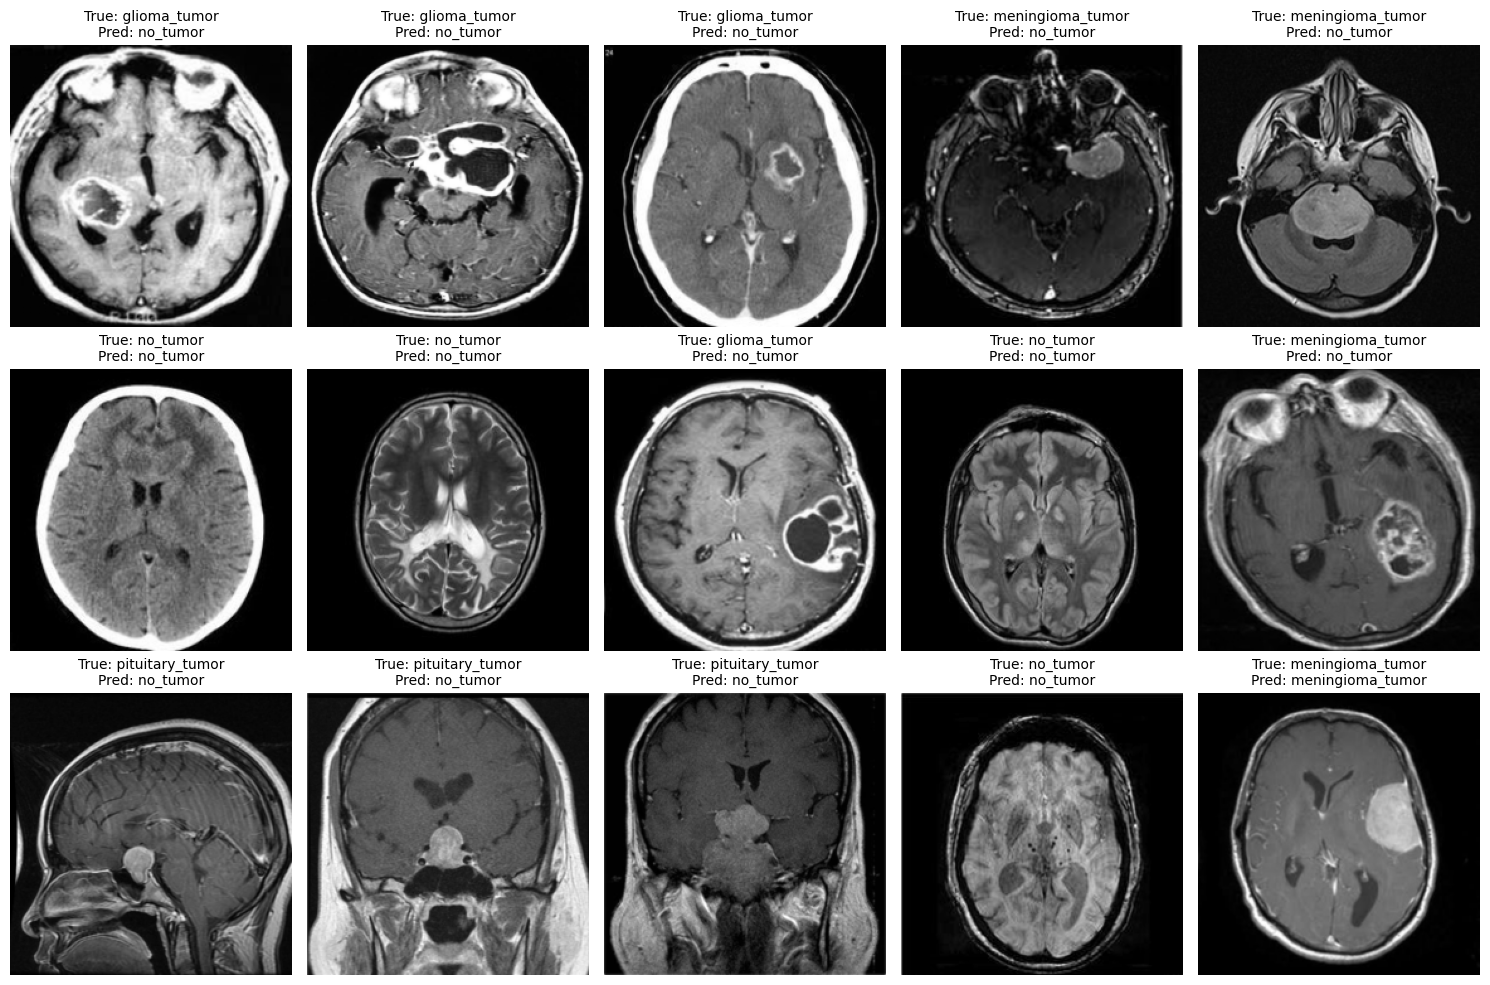

In [73]:
# Predicciones
predictions_g = trainer_g.predict(test_dataset_cvt) # Error en set utilizado, levantar pesos o correr modelo y correr set correcto
predicted_labels_g = torch.argmax(torch.tensor(predictions_g.predictions), dim=-1)

# Ploteo de predicciones y ground truth (labels)
plot_predictions(test_dataset_g, predictions_g, class_names)

#### Matriz de confusión

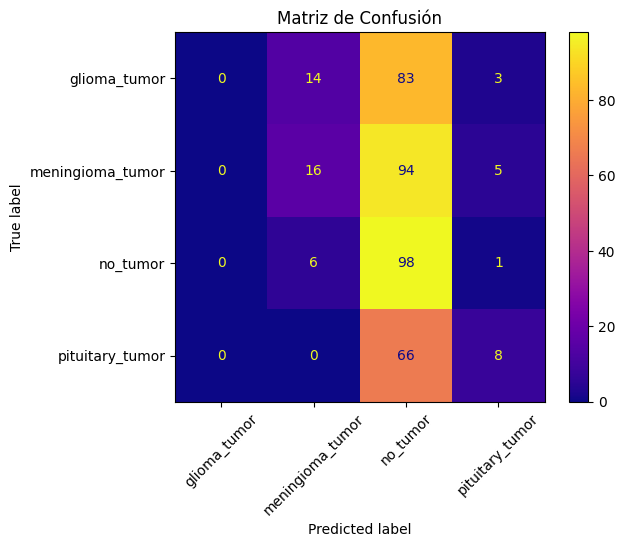

In [75]:
plot_confusion_matrix(predictions_g, class_names)